<img src="gsstanim.gif" width=600 alt="ENSO"></img>

## Resumen
En este cuadernillo (Notebook) aprenderemos:

1. Breve introducción al fenoméno ENOS 
1. Acceso a datos publicos de la NOAA
1. Generación de mapas con anomalias de temperatura superficial del oceano Pacífico Tropical
1. Reproduccion de la gráfica del índice ONI en la región Niño 3.4

## Prerequisitos

| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necesario |  Manejo de datos multidimensionales espacializados|
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necesario |  Generación de gráficas|
| [Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necesario |  Generación de mapas|
| [NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Útil | Familiaridad con la estructura de datos y metadatos. |


- **Tiempo de aprendizaje**: 30 minutos.

# 1. EL Niño - Oscilación del Sur (ENOS)

---

- Alteracion del sistema Océano-Atmósfera
- Fase cálida (positiva) corresponde a El Niño
- Fase fría (negativa) corresponde a La Niña
- Las fases cálidas o frías del Índice del Niño Oceánico se definen por cinco anomalías medias consecutivas de la temperatura de la superficie del mar (TSM) durante cinco meses consecutivos en la región del Niño 3.4 que están por encima del umbral de +0,5 °C (cálido), o por debajo del umbral de -0,5°C (frío). Esto se conoce como Índice del Niño Oceánico (ONI).
- ENOS puede presentarse en intervalos que varían entre 2 y 7 años

La región Niño 3.4 se define como la región entre +/- 5 grados. latitud, 170 W - 120 W longitud.

<img src="nino-regions.gif" width=500 alt="ENSO"></img>

## Librerias

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib import pyplot as plt

%matplotlib inline

## 2. Accesso a los datos de  temperatura de la [NOAA ERSST](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html)

Como lo mencionamos anteriormente usaremos los datos de temperaturas superficiales del mar de la NOAA

In [2]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url,  drop_variables=['time_bnds'])

In [3]:
display(ds)

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2036)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2023-09-03
    DODS_EXTRA.Unlimited_Dimension:  time

Hagamos algunas visualizaciones básicas de los datos, solo para asegurarnos de que parezcan razonables.

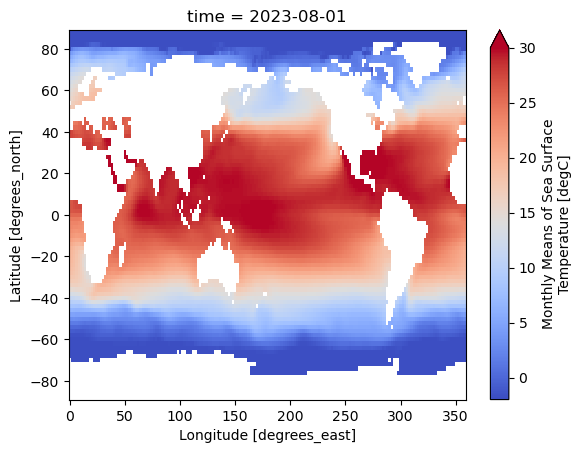

In [4]:
ds.sst[-1].plot(vmin=-2, vmax=30, cmap='coolwarm')

Podemos usar `Cartopy` para "embellecer" el gráfico

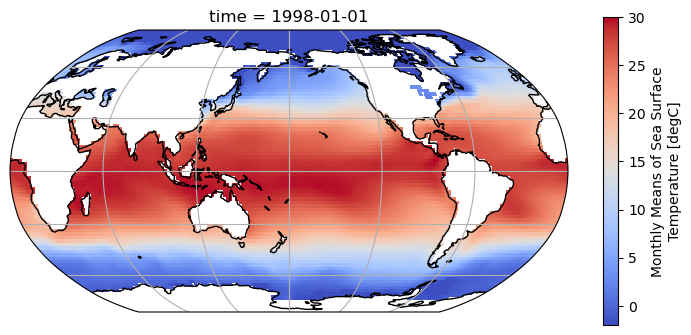

In [5]:
# Definir el tamaño de la figura
fig = plt.figure(figsize=(9, 4))

# Asignar un eje y projección del mapa
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# agregar lineas costeras
ax.coastlines()

# agregar las lineas de reticula (lon and lat)
ax.gridlines()
ds.sst.sel(time='1998-01').plot(vmin=-2, vmax=30, cmap='coolwarm', transform=ccrs.PlateCarree())

## 3. Anomalias de temperatura superficial del oceano Pacífico Tropical

“Anomalía” significa que se ha eliminado el ciclo estacional, también llamado “climatología”.


### 3.1 Climatología
Para estimar la climatología podemos usar la funcionalidad de `xarray` denominada `groupby` donde agrupamos por meses del año y luego tomamos la media a lo largo de cada mes usando el metodo `mean`

In [6]:
sst_clim = ds.sst.groupby('time.month').mean(dim='time')

Ahora podemos visualizar la climatología media zonal

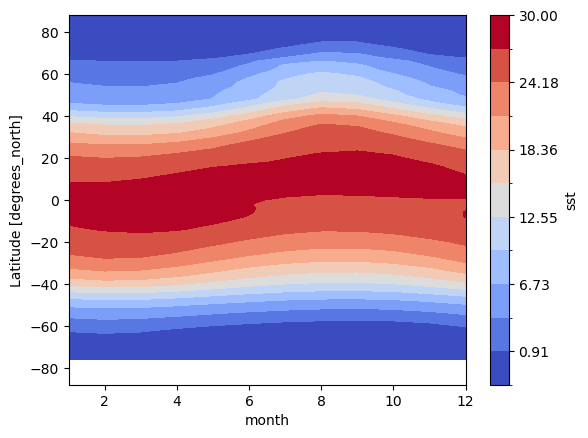

In [7]:
sst_clim.mean(dim='lon').transpose().plot.contourf(levels=12, vmin=-2, vmax=30, 
                                                   cmap='coolwarm')

### 3.2 Cálculo de la anomalía
La anomalía esta dada por el valor de la SST - SST media para cada mes

In [8]:
sst_anom = ds.sst.groupby('time.month') - sst_clim

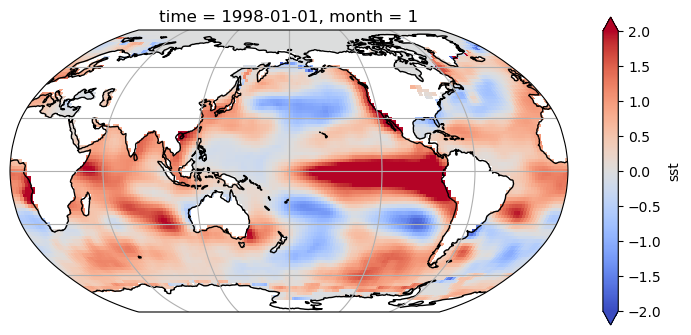

In [9]:
# define the figure size
fig = plt.figure(figsize=(9, 4))

# Asignar un eje y projección del mapa
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# add coastlines
ax.coastlines()

# add gridlines (lon and lat)
ax.gridlines()
sst_anom.sel(time='1998-01').plot(vmin=-2, vmax=2, cmap='coolwarm', transform=ccrs.PlateCarree())

**Momento!!!!** debemos ponderar la anomalia con respecto a su posicion en latitud

<img src="t6_area_average.png" width=600 alt="ENSO"></img>


¿Por qué necesitamos ponderar nuestros datos? Las celdas de la cuadrícula más cercanas al ecuador son mucho más grandes que las cercanas a los polos, como se ve en la figura anterior (Djexplo, 2011, CC-BY)

In [10]:
weights = np.cos(np.deg2rad(ds.lat)).where(~sst_anom[0].isnull())
weights /= weights.mean()

In [11]:
sst_anom_wgt = sst_anom * weights

Veamos cómo se ve el el promedio global vs el promedio ponderado de la anomalía de la temperatura superficial del oceano

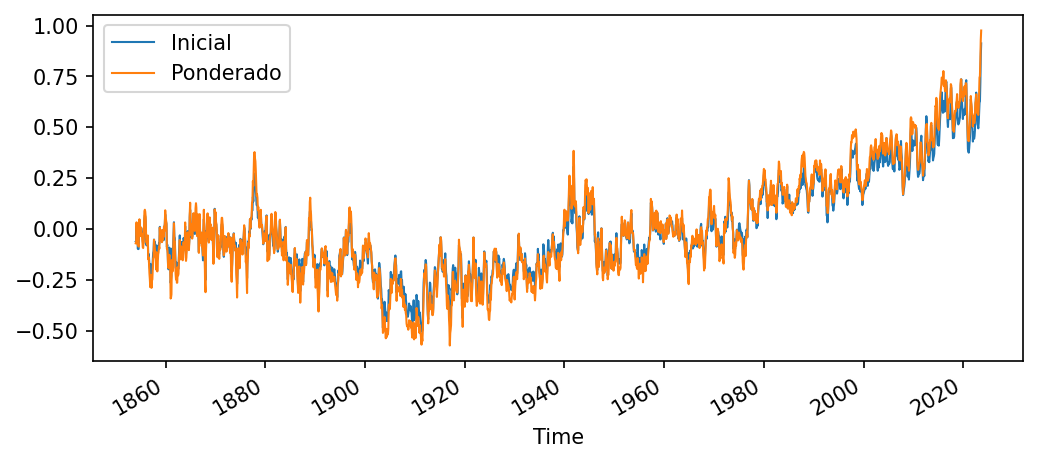

In [12]:
# define the figure size
fig = plt.figure(figsize=(8, 3), dpi=150)

# Asignar un eje
ax = plt.axes()
# Promedio global de la anomalia
(sst_anom).mean(dim=['lon', 'lat']).plot(label='Inicial', lw=1)
# Promedio global de la anomalia ponderada
(sst_anom * weights).mean(dim=['lon', 'lat']).plot(label='Ponderado', lw=1)
ax.legend()

Esta gráfica parece tener una tendencia. El incremento en la temperatura superficial del mar se puede observar despues de ~1950 (CC?). Ahora debememos remover la **tendencia!!!**

In [13]:
from scipy.signal import detrend
sst_anom_wgt_dtd = xr.apply_ufunc(detrend, sst_anom_wgt.fillna(0),
                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

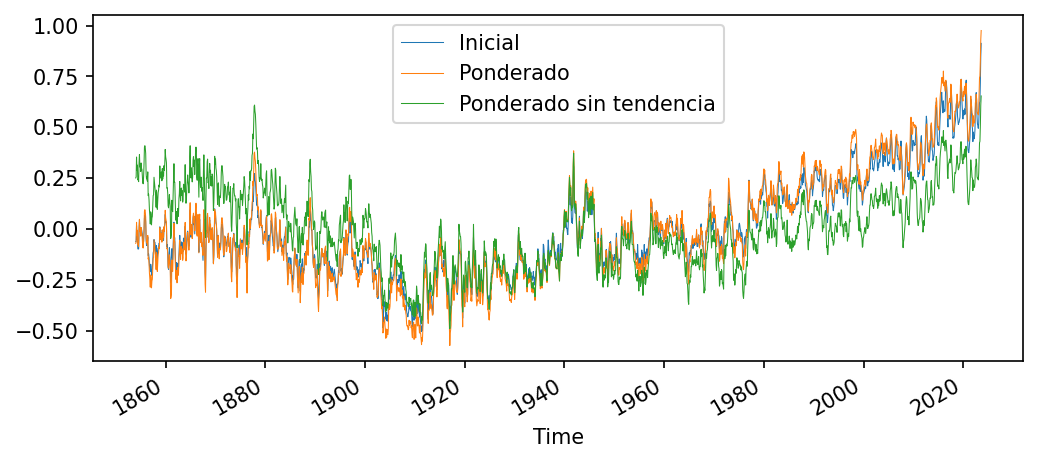

In [14]:
# define the figure size
fig = plt.figure(figsize=(8, 3), dpi=150)

# Asignar un eje
ax = plt.axes()
# Promedio global de la anomalia
sst_anom.mean(dim=['lon', 'lat']).plot(label='Inicial', lw=0.5)
# Promedio global de la anomalia ponderada
sst_anom_wgt.mean(dim=['lon', 'lat']).plot(label='Ponderado', lw=0.5)
# Promedio global de la anomalia ponderada sin tendencia
sst_anom_wgt_dtd.mean(dim=['lon', 'lat']).plot(label='Ponderado sin tendencia', lw=0.5)
ax.legend()


Miremos ahora la anomalia de la SST para enero de 1998

Text(0.5, 1.0, 'Anomalía TSM  1998-01')

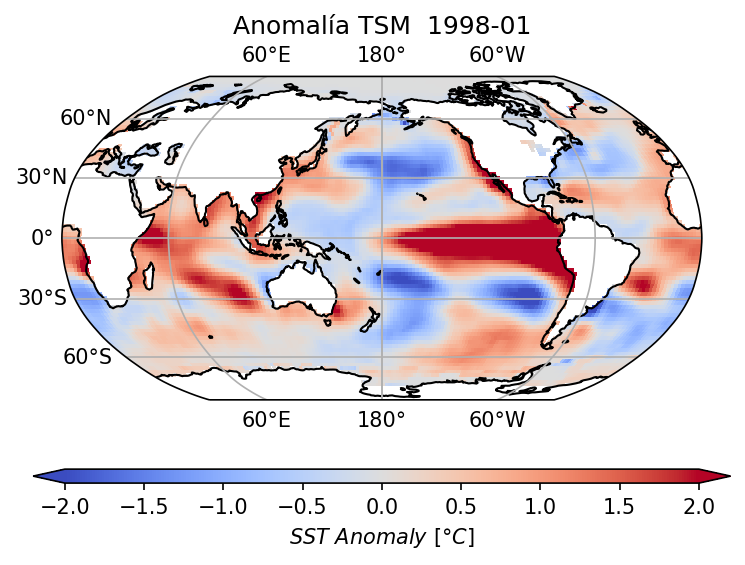

In [16]:
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)}, dpi=150)
sst_anom_wgt_dtd.sel(time='1998-01').plot(vmin=-2, vmax=2, cmap='coolwarm', transform=ccrs.PlateCarree(), 
                                          cbar_kwargs={'label':"$SST \ Anomaly \ [°C]$", 'orientation':'horizontal', 'aspect':50})
ax.coastlines()
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlocator = mticker.FixedLocator([-180, -60, 60, 180])
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
plt.title(f"Anomalía TSM {pd.to_datetime(sst_anom_wgt_dtd.sel(time='1998-01').time[0].values): %Y-%m}")

Veamos qué pasa si cambiamos la proyección del mapa

Text(0.5, 1.0, 'Anomalía TSM  1998-01')

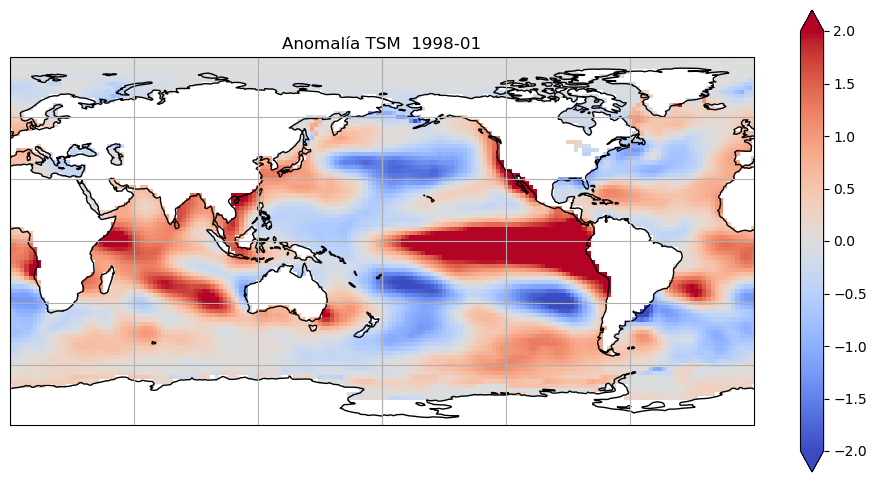

In [15]:
# define the figure size
fig = plt.figure(figsize=(12, 6))

# Asignar un eje y projección del mapa
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# add coastlines
ax.coastlines()

# add gridlines (lon and lat)
ax.gridlines()
sst_anom_wgt_dtd.sel(time='1998-01').plot(vmin=-2, vmax=2, cmap='coolwarm', transform=ccrs.PlateCarree())
plt.title(f"Anomalía TSM {pd.to_datetime(sst_anom_wgt_dtd.sel(time='1998-01').time[0].values): %Y-%m}")

### 3.3 Tratemos de reproducir la grafica de la NOAA

Tratemos de usar nuestra data para generar una grafica como esta:

<img src="nino_2023_agosto.JPG" width=800 alt="ENSO"></img>

In [17]:
sst_anom_sub = sst_anom_wgt_dtd.sel(lat=slice(60, -60), lon=slice(25, 360))

Text(0.5, 1.0, 'Anomalía TSM  1998-01')

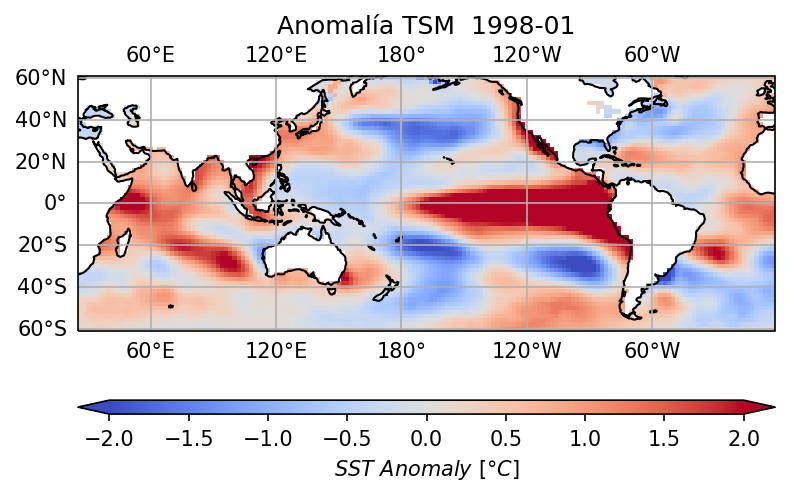

In [18]:
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=180)}, dpi=150)
sst_anom_sub.sel(time='1998-01').plot(vmin=-2, vmax=2, cmap='coolwarm', transform=ccrs.PlateCarree(), 
                                          cbar_kwargs={'label':"$SST \ Anomaly \ [°C]$", 'orientation':'horizontal', 'aspect':50})
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
plt.title(f"Anomalía TSM {pd.to_datetime(sst_anom_wgt_dtd.sel(time='1998-01').time[0].values): %Y-%m}")

## 4. Índice ONI en la región Niño 3.4

<img src="eln-f-pg.gif" width=600 alt="ENSO"></img>

La región Niño 3.4 se define como la región entre +/- 5 grados. latitud, 170 W - 120 W longitud.


In [19]:
nino_34 = sst_anom_wgt_dtd.sel(lat=slice(5, -5), lon=slice(180 - (180-170), 180 + (180-120)))

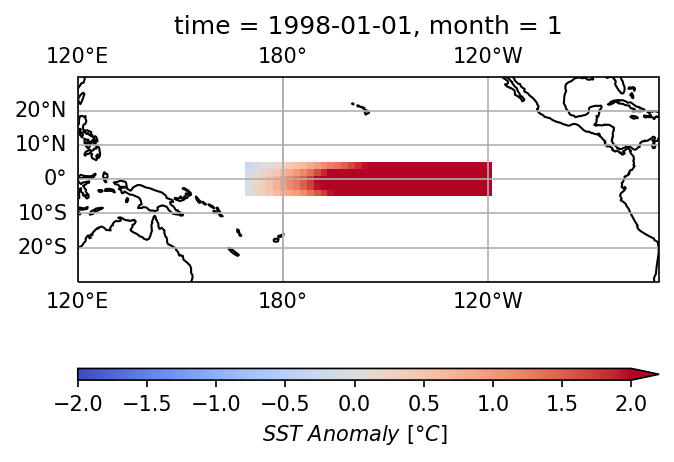

In [20]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=180)}, dpi=150)
nino_34.sel(time='1998-01').plot(vmin=-2, vmax=2, cmap='coolwarm', transform=ccrs.PlateCarree(), 
                                          cbar_kwargs={'label':"$SST \ Anomaly \ [°C]$", 'orientation':'horizontal', 'aspect':50})
ax.coastlines()
ax.set_extent([120, 290, -30,30], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

Ahora podemos generar nuestro indice ONI con una ventana móvil de 3 meses

In [21]:
oni = nino_34.mean(['lat', 'lon']).rolling(time=3, center=True).mean()

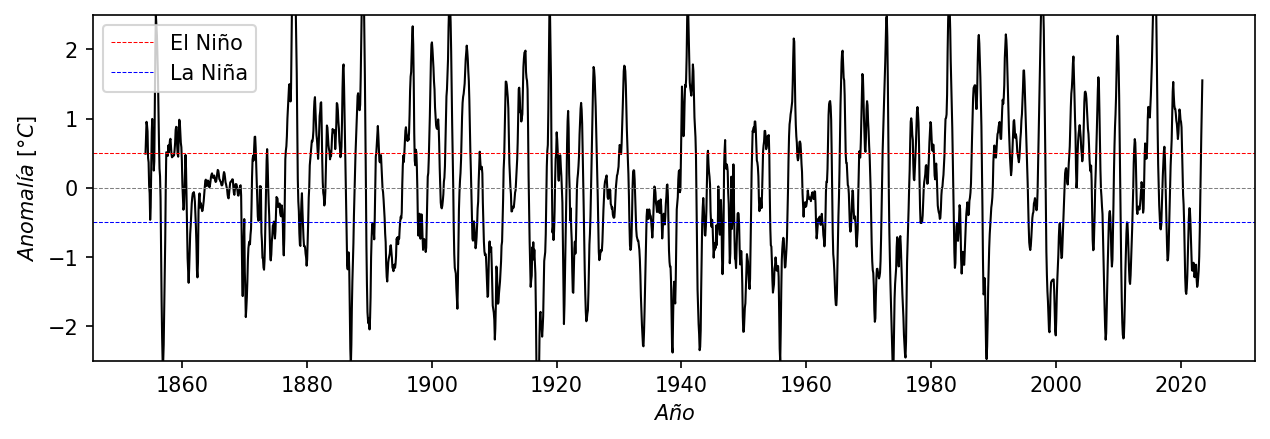

In [22]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(oni.time, oni, lw=1, c='k')
ax.axhline(0, c='grey', lw=0.5, ls='--')
ax.axhline(0.5, c='r', lw=0.5, ls='--', label='El Niño')
ax.axhline(-0.5, c='b', lw=0.5, ls='--',  label='La Niña')
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('$Año$')
ax.set_ylabel('$Anomalía \ [°C]$')
ax.legend()

Podemos selesccionar los ultimos **70 años** para efectos de visualización

In [23]:
oni_sub = oni.sel(time=slice('1950', '2023'))

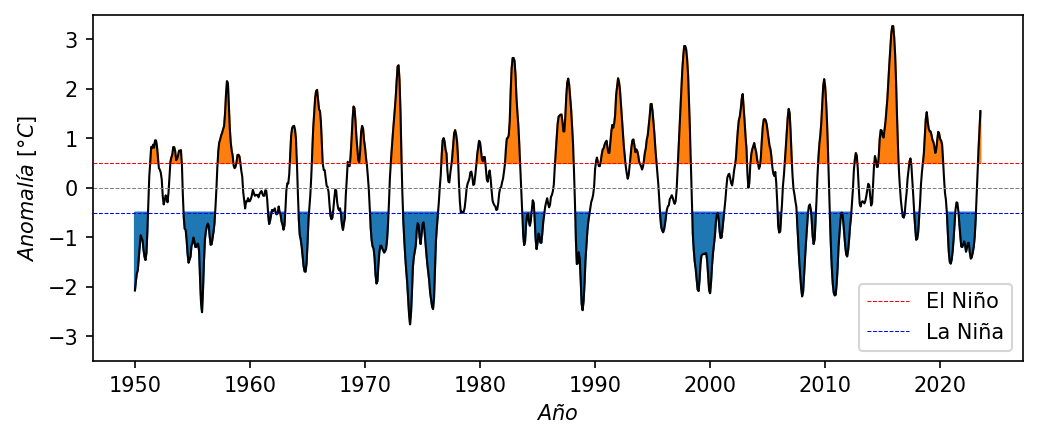

In [24]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
ax.plot(oni_sub.time, oni_sub, lw=1, c='k')
ax.axhline(0, c='grey', lw=0.5, ls='--')
ax.axhline(0.5, c='r', lw=0.5, ls='--', label='El Niño')
ax.axhline(-0.5, c='b', lw=0.5, ls='--',  label='La Niña')
ax.fill_between(oni_sub.time, 0.5, oni_sub.where(oni_sub >= 0.5), color='C01')
ax.fill_between(oni_sub.time, -0.5, oni_sub.where(oni_sub <= -0.5), color='C00')

ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$Año$')
ax.set_ylabel('$Anomalía \ [°C]$')
ax.legend()